<a href="https://colab.research.google.com/github/aisling-mol/Mapping-Cognitive-Control-EEG-Signals-Modulating-Real-Time-Musical-Parameters/blob/a_Colab_SampleEDFCode/SampleVersionofCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install MNE

In [ ]:
!pip install mne

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import time

# Load EDF file

In [ ]:
edf_path = '/content/sub-1_task-oa_eeg.edf'  # Update path as needed
raw = mne.io.read_raw_edf(edf_path, preload=True)

Extracting EDF parameters from /content/sub-1_task-oa_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 103999  =      0.000 ...   207.998 secs...


# Pick EEG channels only


In [ ]:
raw.pick_types(eeg=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<RawEDF | sub-1_task-oa_eeg.edf, 20 x 104000 (208.0 s), ~15.9 MiB, data loaded>

In [ ]:
print(raw)
print(raw.info)

<RawEDF | sub-1_task-oa_eeg.edf, 20 x 104000 (208.0 s), ~15.9 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-A1A2, EEG Fp2-A1A2, EEG Fz-A1A2, EEG F3-A1A2, EEG ...
 chs: 20 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 60.0 Hz
 meas_date: 2016-10-14 12:37:25 UTC
 nchan: 20
 projs: []
 sfreq: 500.0 Hz
 subject_info: <subject_info | his_id: Virginia, sex: 0, last_name: X>
>


Effective window size : 4.096 (s)


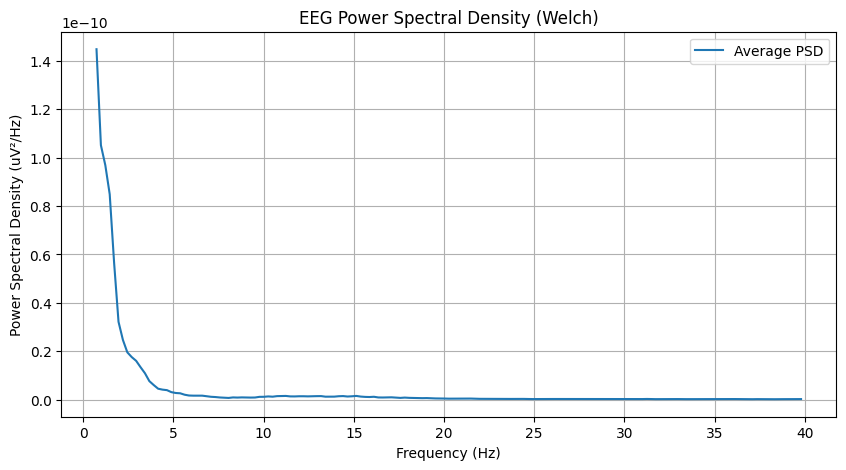

In [ ]:
# Compute PSD using Welch's method
psd = raw.compute_psd(method='welch', fmin=0.5, fmax=40, n_fft=2048)
psds = psd.get_data()
freqs = psd.freqs

# Average across channels
psd_mean = psds.mean(axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, psd_mean, label='Average PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (uV²/Hz)')
plt.title('EEG Power Spectral Density (Welch)')
plt.grid(True)
plt.legend()
plt.show()

# Set parameters

In [ ]:
sfreq = int(raw.info['sfreq'])  # Sampling frequency
chunk_size = sfreq  # 1-second chunks
total_samples = raw.n_times
n_channels = len(raw.ch_names)
n_chunks = (total_samples - chunk_size) // chunk_size

# Frequency bands
bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (13, 30),
}

Visualise

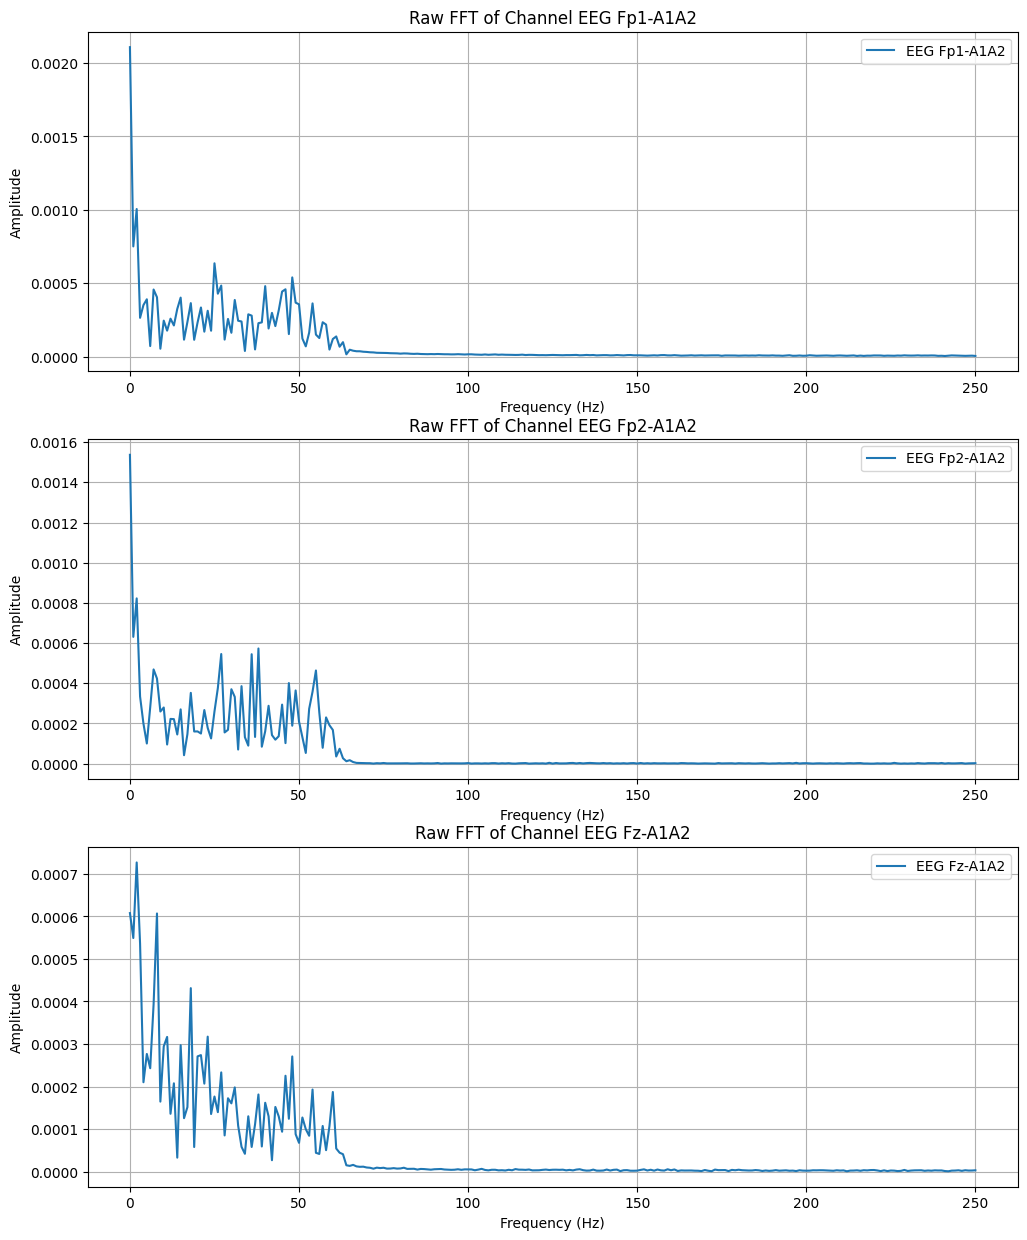

In [ ]:
# Get 1-second EEG data (e.g., first 1 sec)
data, times = raw[:, :chunk_size]  # EEG data: shape (n_channels, chunk_size)

# FFT
fft_vals = np.abs(np.fft.rfft(data, axis=1))
freqs = np.fft.rfftfreq(chunk_size, 1 / sfreq)

# Plot FFT of Frontal EEG channels
channel_idx1 = 0
channel_idx2 = 1
channel_idx3 = 2
plt.figure(figsize=(12, 15))
# Create the subplot first
ax = plt.subplot(3, 1, 1)
# Then plot the data on the created axes
ax.plot(freqs, fft_vals[channel_idx1], label=raw.ch_names[channel_idx1])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
# Use channel_idx1 in the title
ax.set_title(f'Raw FFT of Channel {raw.ch_names[channel_idx1]}')
ax.grid(True)
ax.legend()

# Create the subplot first
ax = plt.subplot(3, 1, 2)
# Then plot the data on the created axes
ax.plot(freqs, fft_vals[channel_idx2], label=raw.ch_names[channel_idx2])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
# Use channel_idx1 in the title
ax.set_title(f'Raw FFT of Channel {raw.ch_names[channel_idx2]}')
ax.grid(True)
ax.legend()

# Create the subplot first
ax = plt.subplot(3, 1, 3)
# Then plot the data on the created axes
ax.plot(freqs, fft_vals[channel_idx3], label=raw.ch_names[channel_idx3])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
# Use channel_idx1 in the title
ax.set_title(f'Raw FFT of Channel {raw.ch_names[channel_idx3]}')
ax.grid(True)
ax.legend()

plt.show()

Using matplotlib as 2D backend.


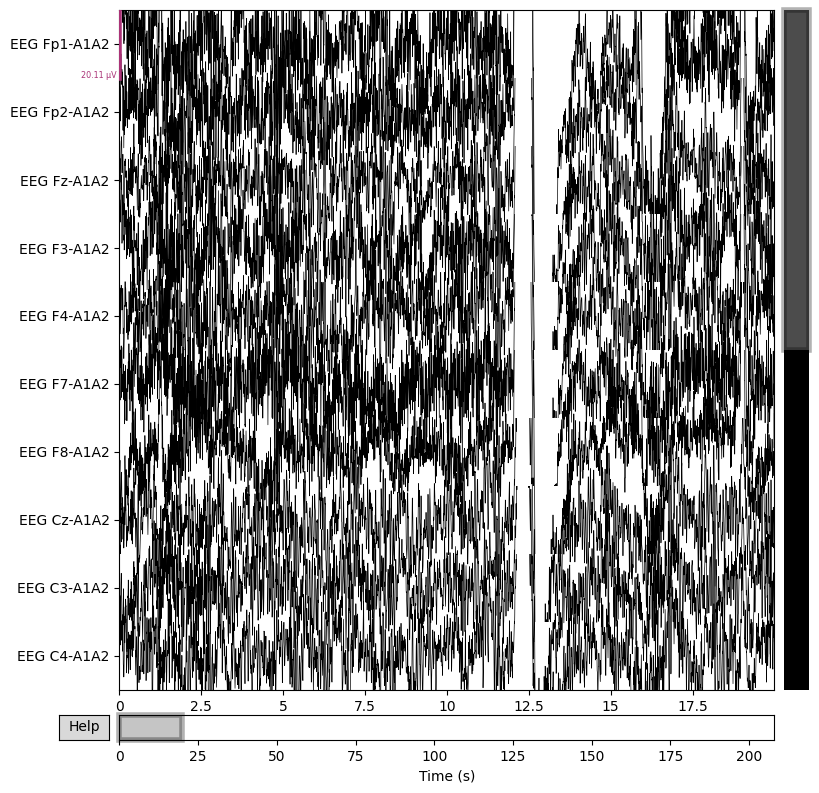

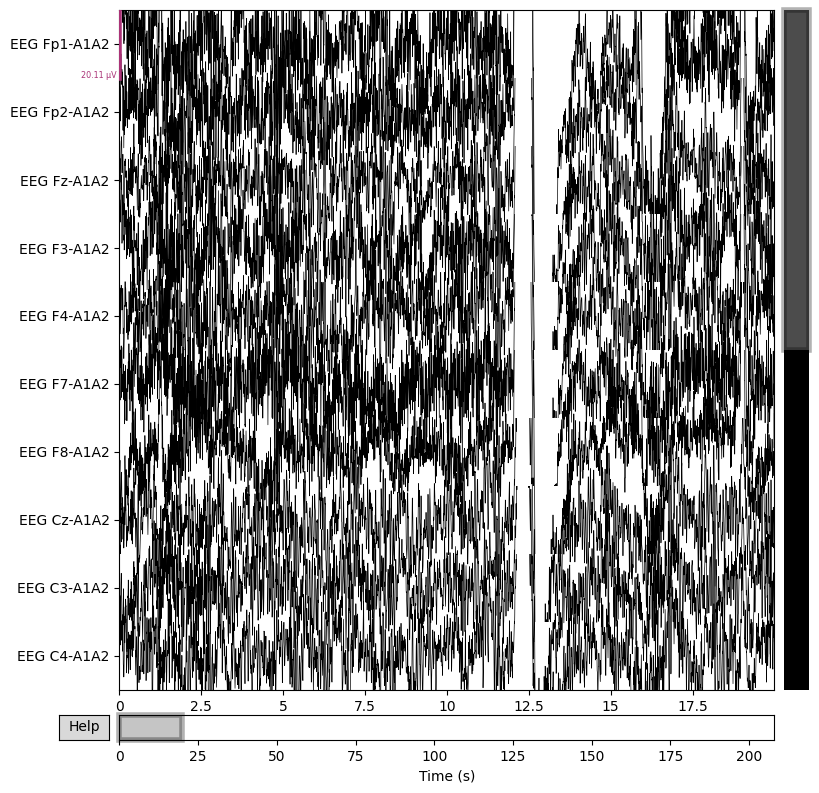

In [ ]:
raw.plot(n_channels=10, duration=20, scalings='auto', title='Raw EEG')

ReReference using Fx

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


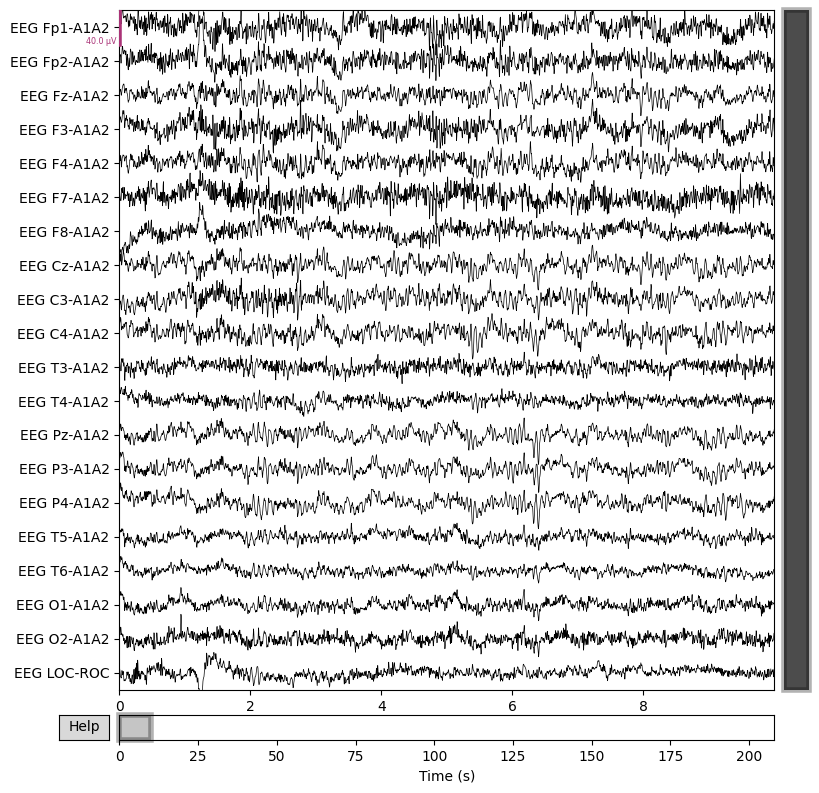

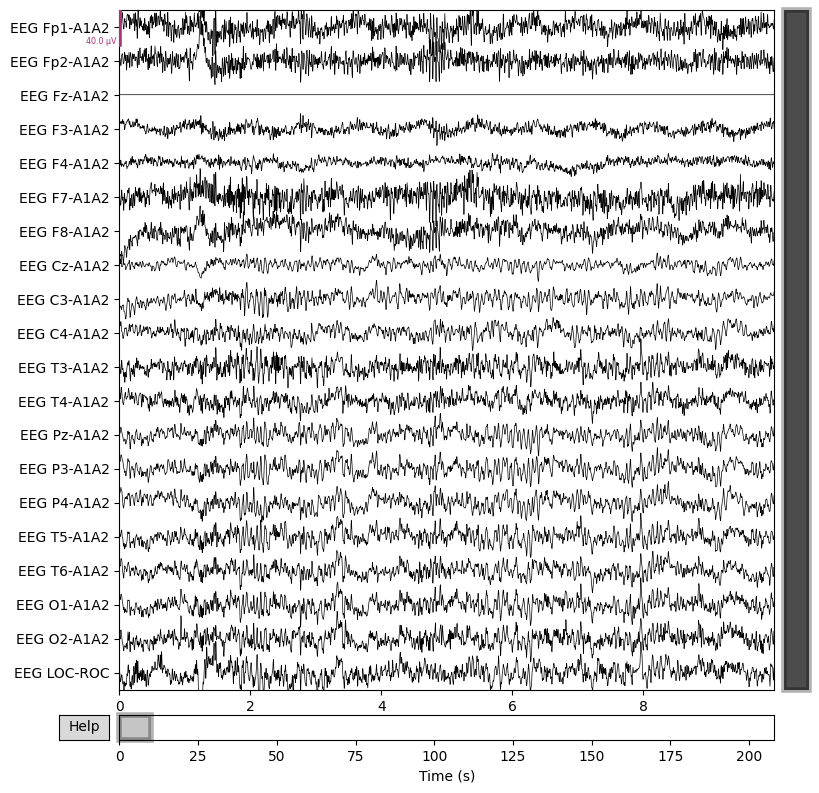

In [ ]:
rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ["EEG Fz-A1A2"], copy=True)
fig_orig = raw.plot()
fig_reref = rereferenced_raw.plot()

Check for Events

In [ ]:
if raw.annotations:
    events, _ = mne.events_from_annotations(raw)
    mne.viz.plot_events(events, sfreq=sfreq, first_samp=raw.first_samp)

# Step 4: Simulate real-time feed

In [ ]:
# Storage for visualization
band_history = {band: [] for band in bands}
midi_history = {band: [] for band in bands}
time_stamps = []

In [ ]:
# Process data in chunks
for i in range(n_chunks):
    start = i * chunk_size
    stop = start + chunk_size
    data, _ = raw[:, start:stop]

    fft_vals = np.abs(np.fft.rfft(data, axis=1))
    freqs = np.fft.rfftfreq(chunk_size, 1 / sfreq)

# Step 5: Compute band amplitudes

In [ ]:
band_amps = {}
for band, (fmin, fmax) in bands.items():
        mask = (freqs >= fmin) & (freqs <= fmax)
        power = fft_vals[:, mask].mean(axis=1).mean()
        band_amps[band] = power
        band_history[band].append(power)

# Normalize to MIDI [0–127]

In [ ]:
max_amp = max(band_amps.values()) or 1e-6  # avoid div by zero
midi_values = {
        band: int(np.clip((amp / max_amp) * 127, 0, 127))
        for band, amp in band_amps.items()
    }

for band in bands:
        midi_history[band].append(midi_values[band])

# Output MIDI String

In [ ]:
 # Output MIDI string
midi_str = ", ".join(f"{band.upper()}={val}" for band, val in midi_values.items())
print(f"[{i:02d}s] MIDI: {midi_str}")

time_stamps.append(i)
time.sleep(0.1)  # Simulated fast live feed for demo

[206s] MIDI: DELTA=127, THETA=78, ALPHA=88, BETA=66


Plot of Band Power Time Series

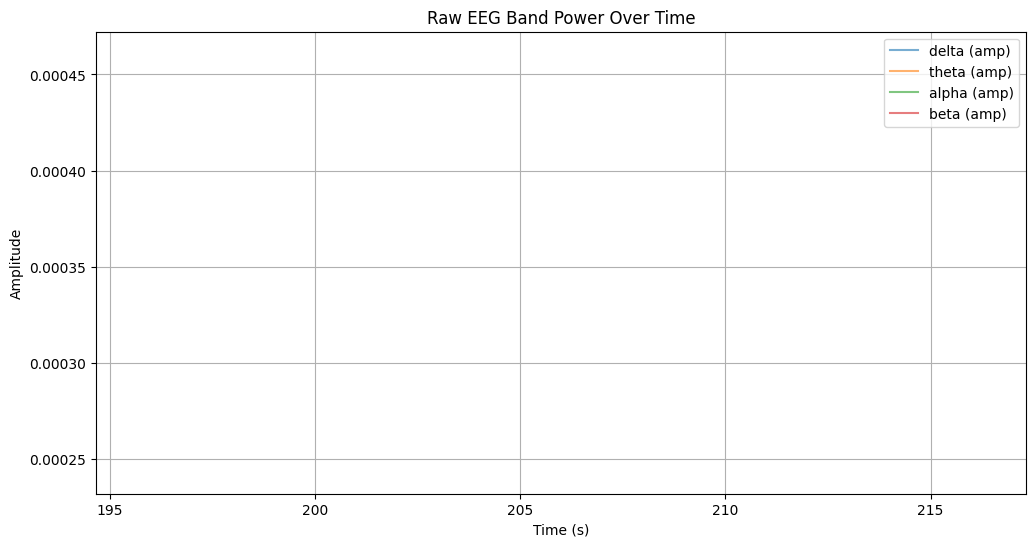

In [ ]:
for band in bands:
    if len(band_history[band]) != len(time_stamps):
        print(f"Warning: Mismatch in lengths for band '{band}'")

plt.figure(figsize=(12, 6))
for band in bands:
  plt.plot(time_stamps, band_history[band], label=f"{band} (amp)", alpha=0.6)
plt.title("Raw EEG Band Power Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

Plot MIDI Values Over Time

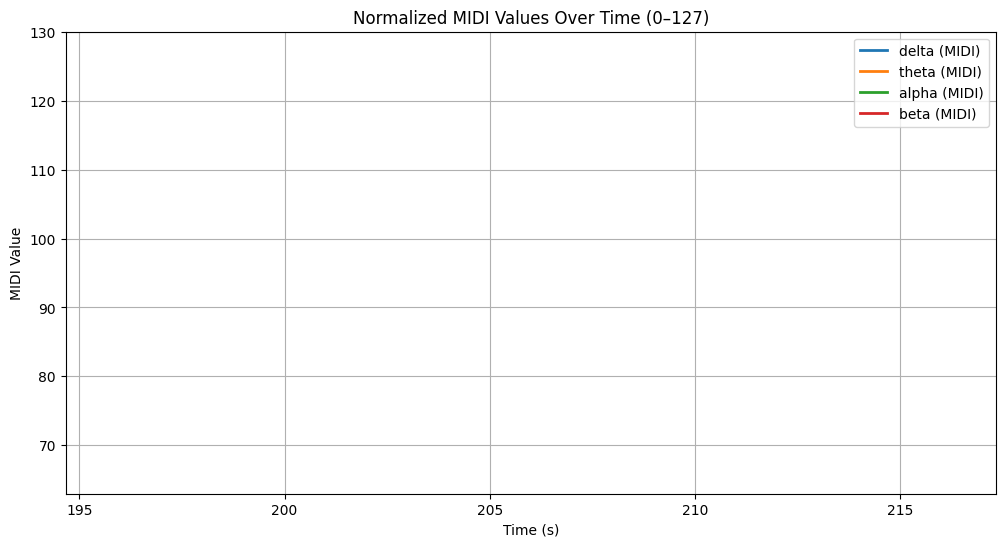

In [ ]:
plt.figure(figsize=(12, 6))
for band in bands:
    plt.plot(time_stamps, midi_history[band], label=f"{band} (MIDI)", linewidth=2)
plt.title("Normalized MIDI Values Over Time (0–127)")
plt.xlabel("Time (s)")
plt.ylabel("MIDI Value")
plt.legend()
plt.grid(True)
plt.show()